In [1]:
#imports
import numpy as np
import numpy.random as rd
import numpy.linalg as linalg
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from hmmlearn import hmm
import cvxopt

In [2]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1.0
    return 0.0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def dot(x,y):
    return np.sum(np.multiply(x,y))

In [3]:
en = 3
ch = 3
P = np.array([.2,.4,.4])
E = np.array([[.5,.6,.4],[.2,.3,.1],[.4,.5,.3]])
R = np.array([8.,6.,4.])
# P = row_normalize([np.random.rand(ch)/2])[0]
# E = np.random.rand(en,ch)/2
# R = np.array([np.random.randint(1,10) for i in range(en)])
tol = .3
print(P)
print(E)
print(R)

[0.2 0.4 0.4]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]
[8. 6. 4.]


In [25]:
ub = np.sum(E*P,axis=1)
ltemp = linprog(c = -1*R, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(min(ub))
print(dot(ltemp.x,R), np.sum(ltemp.x),ltemp.con, ltemp.success, dot(ltemp.x,ub))
org_x = ltemp.x
print(ltemp.x)

0.2
6.666666666666666 1.0 [0.] True 0.3
[0.33333333 0.66666667 0.        ]


In [26]:
print(en,ch,tol,np.dot(ltemp.x,R),min(ub))
print(P)
print(E)
print(ltemp.x)

3 3 0.3 6.666666666666666 0.2
[0.2 0.4 0.4]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]
[0.33333333 0.66666667 0.        ]


In [27]:
# finding safe x0
ub = E.transpose();tol_arr = [tol]*ch
ltemp = linprog(c=np.zeros(en),A_ub = ub,b_ub=tol_arr,A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-3})
x0 = np.transpose(row_normalize([ltemp.x+(0.0)])) # noise to safe to avoid singular matrices, 1.0e-2 is working
norm_x0 = linalg.norm(x0)
e0 = x0/norm_x0 # safe vector
e0_trans = e0.transpose()
en0 = sample(x0.transpose()[0])
b0 = bernoulli(E[en0][sample(P)])
yt = (E[en0]*(1-b0))+((1-E[en0])*b0)
yt = row_normalize([np.exp(yt)]).transpose()
c0 = dot(x0,np.matmul(E,yt)) # safe cost
print(np.array(x0),c0)

[[0.]
 [1.]
 [0.]] 0.1933444204244802


In [ ]:
# parameters
reg = 0.1 # lambda > 0, regualarization param
conf = 0.1 # delta >= 0, <= 1, confidence prob -> with 1-del prob tolerance holds
alfa_c = 1.0 # >= 1, ellipse radii, best : 0.001
Sa = 1.;La = 1.;Ra = 1. # assumption parameters
R_sum = np.sum(R)
Rn_trans = R/R_sum
Rn = np.transpose([Rn_trans])
# x = [np.transpose(row_normalize([np.ones(en)]))]
x = [x0]
r = [dot(x[-1],Rn)];c = [c0]
b = []; enc = [];chnl = []
rate = []

In [ ]:
def qclp_solver(A,C,x0,Rn,en,tol):
    A = cvxopt.matrix(A)
    C = cvxopt.matrix(C)
    x0 = cvxopt.matrix(x0)
    Rn = cvxopt.matrix(Rn)
    def F(x = None, z = None):
        if x is None:  return (1, x0)
        noise = 1.0e-2
        if max(x) > 1.0+noise or min(x) < 0.0-noise: return (None,None)
        f = (A*x) +  (x.trans()*C*x) - cvxopt.matrix([tol])
        df = A + (2.0*C*x).trans()
        if z is None: return (f,df)
        h = 2*z[0]*C
        return (f,df,h)
    sol = cvxopt.solvers.cpl(-1*Rn, F, None, None, None, cvxopt.matrix([1.0]*en).trans(), cvxopt.matrix([1.0]),kktsolver='ldl', options={'show_progress':True,'kktreg':1e-2})['x']
    return np.array(sol), ((A*sol)+(sol.trans()*C*sol))[0]
# 'kktreg':1e-9, kktsolver='ldl',

In [ ]:
# algo
iop = np.identity(en) - (np.matmul(x0,x0.transpose())/pow(norm_x0,2.0))
sigopt = reg*iop; uopt = 0.0
for t in range(1,10):
    enc.append(sample(x[-1].transpose()[0]))
    chnl.append(sample(P))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    # yt = (E[enc[-1]]*(1-b[-1]))+((1-E[enc[-1]])*b[-1])
    # yt = row_normalize([np.exp(yt)]).transpose()
    r.append(dot(x[-1],Rn))
    c.append(1.0 - b[-1])  # c.append(dot(x[-1],np.matmul(E,yt)))
    copt = c[-1] - (dot(x[-1],e0)/norm_x0)*c[0]
    xopt = x[-1] - (dot(x[-1],e0)*e0)
    sigopt += np.matmul(xopt,xopt.transpose())
    uopt += (copt*xopt)
    muopt = np.matmul(linalg.pinv(sigopt),uopt) # (inverse is blowing up, singular matrices) so did pseudo(SVD)
    A = (((c[0]/norm_x0)*e0_trans)+muopt.transpose()+(dot(e0,muopt)*e0_trans))
    betat = Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/reg)/conf))+math.sqrt(reg)*Sa # used log10
    d = -2*alfa_c*betat
    l = alfa_c*betat*(1+pow(dot(e0,e0),2.0))
    C = ((l*np.identity(en)) + (d*np.matmul(e0,e0_trans)))
    sol = qclp_solver(A,C,x0,Rn,en,t)
    x.append(sol[0])
    rate.append(dot(x[-1],Rn)*R_sum)
    print(t,rate[-1],sol[1])
# print(copt)
# print(xopt)
# print(sigopt)
# print(uopt)
# print(muopt)
# print(A,betat)

In [13]:
x[-1]

array([[0.01390524],
       [0.76630852],
       [0.01390436]])

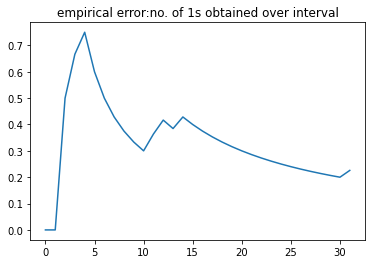

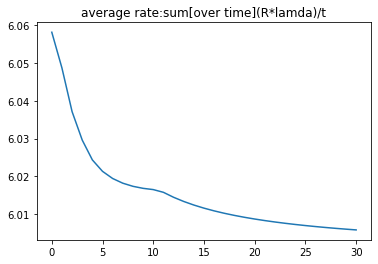

In [113]:
stat = 0
error_plot = 1.0 - np.copy(b)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[stat:])
plt.title('empirical error:no. of 1s obtained over interval')
plt.show()
rate_plot = np.copy(rate)
for i in range(1,len(rate_plot)):
    rate_plot[i] += (rate_plot[i-1]*(i-1))
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[stat:])
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()

In [114]:
print(x[-1].flatten())
print(rate_plot[-1],error_plot[-1])
print(x[0].flatten())

[-0.00e+000  1.00e+000  4.94e-322]
6.005771867611344 0.22580645161290322
[0. 1. 0.]


27.216552697590863


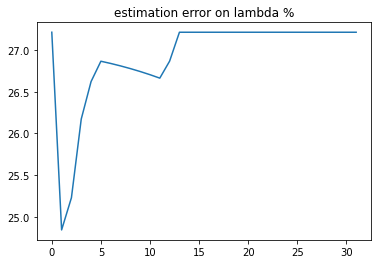

In [115]:
err = []
for i in x:
    err.append(np.sqrt(np.sum(np.square(org_x-i.flatten()))/en)*100)
print(err[-1])
plt.plot(err[stat:])
plt.title('estimation error on lambda %')
plt.show()

In [ ]:
(Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/.1)/0.9))+math.sqrt(.1)*Sa)*linalg.norm(xopt) 

In [ ]:
alfa_c -> lamda error %
0.0 -> 0.7263980978187543
0.0001 -> 0.64
0.001 -> 0.17
0.005 -> 4

In [74]:
import cvxopt
from cvxopt import matrix

In [ ]:
a = matrix([[2.],[3.]])
b = matrix([[1.,2.],[2.,1.]])
c = matrix([[6.],[4.]])
tol = 5
A = matrix([1.0]*2).trans()
def F(x = None, z = None):
    if x is None:  return 1, matrix([[1.,0.]])
    if max(x) > 1.0 or min(x) < 0: return (None,None)
    f = (a*x) +  x.trans()*b*x - tol
    df = a + (2*b*x).trans()
    if z is None: return (f,df)
    h = 2*z*b
    return (f,df,h)

In [106]:
def qclp_solver(A,C,x0,Rn,en,tol):
    A = cvxopt.matrix(A)
    C = cvxopt.matrix(C)
    x0 = cvxopt.matrix(x0)
    Rn = cvxopt.matrix(Rn)
    def F(x = None, z = None):
        if x is None:  return (1, x0)
        if max(x) > 1.0 or min(x) < 0.0: return (None,None)
        f = (A*x) +  (x.trans()*C*x) - cvxopt.matrix([tol])
        df = A + (2.0*C*x).trans()
        if z is None: return (f,df)
        h = 2*z[0]*C
        return (f,df,h)
    sol = cvxopt.solvers.cpl(-1*Rn, F, None, None, None, cvxopt.matrix([1.0]*en).trans(), cvxopt.matrix([1.0]),kktsolver='ldl', options={'show_progress':True,'kktreg':1e-5})['x']
    return np.array(sol), ((A*sol)+(sol.trans()*C*sol))[0]
a = matrix([[2.],[3.]])
b = matrix([[0.,0.],[0.,0.]])
c = matrix([[7.,9.]])
a = qclp_solver(a,b,matrix([[.1,.9]]),c,2,2.3)
print(a)
print(c.trans()*matrix(a[0]))

     pcost       dcost       gap    pres   dres
 0: -8.8000e+00 -8.2000e+00  1e+00  1e+00  1e+00
 1: -8.9697e+00 -7.8974e+00  2e-02  4e-01  4e-01
 2: -7.9124e+00 -7.6153e+00  2e-04  1e-01  1e-01
 3: -7.6182e+00 -7.6001e+00  2e-06  6e-03  6e-03
 4: -7.6002e+00 -7.6000e+00  2e-08  7e-05  7e-05
 5: -7.6000e+00 -7.6000e+00  2e-10  7e-07  7e-07
 6: -7.6000e+00 -7.6000e+00  2e-12  7e-09  7e-09
Optimal solution found.
(array([[0.69999999],
       [0.30000001]]), 2.300000011735435)
[ 7.60e+00]



In [ ]:
print(sol['x'])
x = sol['x']
print((a*x) +  x.trans()*b*x - tol)
print(-1*c.trans()*x)

In [ ]:
matrix(np.array([[2.],[3.]])), matrix([[2.],[3.]])

In [ ]:
m = matrix([[1.0]])
print(m - tol, m - matrix([[.2]]))